# Covid19 Exploratory Analysis
## by Tuan Bui

## Preliminary Wrangling

- The main dataset for the 2019 Novel Coronavirus collected and maintained by [Our World in Data](https://ourworldindata.org/coronavirus). It is updated daily and includes data on confirmed cases, deaths, and testing, as well as other variables of potential interest. The dataset is downloaded from https://github.com/owid/covid-19-data/tree/master/public/data
- Dataset contains the number of nurses per 1000 people can be download from the link https://data.worldbank.org/indicator/SH.MED.NUMW.P3?view=chart
- Dataset contains information about Covid19 and GDP per capita can be downloaded from https://ourworldindata.org/grapher/total-confirmed-cases-of-covid-19-per-million-people-vs-gdp-per-capita
- Dataset contains information about GDP growth can be downloaded from the link https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import glob
from os import path

%matplotlib inline

In [2]:
if not path.exists("covid19.csv"):
    folder = "csse_covid_19_data/csse_covid_19_daily_reports/"
    df = pd.DataFrame()
    features = ['Province_State',
     'Country_Region',
     'Last_Update',
     'Confirmed',
     'Deaths',
     'Recovered',
     'FIPS',
     'Admin2',
     'Latitude',
     'Longitude',
     'Active',
     'Combined_Key']
    duplicated_names = {'Bahamas, The':'Bahamas',
                   'Mainland China':'China',
                   'Czechia':'Czech Republic', 
                   'Dominican Republic':'Dominica',
                   'Gambia, The':'Gambia',
                   'Hong Kong SAR':'Hong Kong',
                   'Iran (Islamic Republic of)':'Iran',
                   'Korea, South':'South Korea',
                    'Republic of Korea':'South Korea',
                   'Republic of Ireland':'Ireland',
                   'Macau SAR': 'Macao', 
                    'Macao SAR':'Macao',
                        'Macau':'Macao',
                    'Republic of Moldova':'Moldova',
                    'Republic of the Congo':'Congo',
                    'Congo (Brazzaville)':'Congo',
                    'Congo (Kinshasa)':'Congo',
                    'Russian Federation':'Russia',
                    'St. Martin':'Saint Martin',
                    'The Bahamas':'Bahamas',
                    'The Gambia':'Gambia',
                    'Taiwan*':'Taiwan',
                    'United Kingdom':'UK',
                    'Viet Nam':'Vietnam'
                       }
    count = 0
    for one_day in sorted(glob.glob(folder+'*.csv')):
        one_day_df = pd.read_csv(str(one_day))
        cols = one_day_df.columns
        for col in cols:
            if col.find("Province/State")>=0:
                one_day_df.rename(columns = {col:"Province_State"},inplace=True)
            elif col.find("Country/Region")>=0:
                one_day_df.rename(columns = {col:"Country_Region"},inplace=True)
            elif col.find("Last Update")>=0:
                one_day_df.rename(columns = {col:"Last_Update"},inplace=True)
            elif col.find("Lat")>=0:
                one_day_df.rename(columns = {col:"Latitude"},inplace=True)
            elif col.find("Long")>=0:
                one_day_df.rename(columns = {col:"Longitude"},inplace=True)       
        for feature in features:
            if not feature in one_day_df.columns:
                one_day_df[feature] = np.NaN
    #    one_day_df.Province_State.fillna("",inplace=True)
        one_day_df['Country_Region'] = one_day_df['Country_Region'].replace(to_replace = duplicated_names)
        one_day_df['Province'] = one_day_df.apply(lambda x: x.Country_Region+'/'+x.Province_State if not pd.isnull(x.Province_State) else x.Country_Region,axis=1)

        one_day_df.Last_Update = pd.to_datetime(one_day_df.Last_Update,dayfirst=False).dt.date
        one_day_df = one_day_df.groupby(['Last_Update','Country_Region','Province']).agg({'Latitude':'mean','Longitude':'mean',
                                                 'Confirmed':'sum','Deaths':'sum','Recovered':'sum',
                                                  'Active':'sum'}).reset_index()
        df = pd.concat([df,one_day_df], axis=0, ignore_index=True,sort=False)

    df.set_index('Province',inplace=True)
    df = df[~(df.Latitude==0)]

    lat_lng = df.groupby('Province').agg({'Latitude':'max','Longitude':'max'}).reset_index()
    lat_lng.set_index('Province',inplace=True)
    df.update(lat_lng)
    df.reset_index(inplace=True)
    df.dropna(inplace=True)

    change_names = {'Korea':'South Korea',
                   'United States of America':'US',
                    'Russian Federation':'Russia',
                    'United Kingdom of Great Britain and Northern Ireland':'UK',
                    'Macedonia':'North Macedonia',
                    'Brunei Darussalam':'Brunei',
                    '''Lao People's Democratic Republic''':'Laos',
                    'Syrian Arab Republic':'Syria',
                    'Timor-Leste':'East Timor'
                   }
    continents = pd.read_csv('countryContinent.csv',encoding = "ISO-8859-1")
    continents = continents[['country','continent']]
    continents.rename(columns={'country':'Country_Region','continent':'Continent'},inplace=True)
    continents.Country_Region = continents.Country_Region.apply(lambda x: x.split('(')[0].strip())
    continents.Country_Region = continents.Country_Region.apply(lambda x: x.split(',')[0].strip())
    continents['Country_Region'] = continents['Country_Region'].replace(to_replace = change_names)

    df = pd.merge(df,continents,how='left',on = 'Country_Region')
    df.dropna(inplace=True)

    df.to_csv("covid19.csv",index=False)

In [3]:
df = pd.read_csv('covid19.csv')

In [4]:
df.head()

,Province,Last_Update,Country_Region,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Continent
0,China/Anhui,2020-01-22,China,31.8257,117.2264,1.0,0.0,0.0,0.0,Asia
1,China/Beijing,2020-01-22,China,40.1824,116.4142,14.0,0.0,0.0,0.0,Asia
2,China/Chongqing,2020-01-22,China,30.0572,107.8740,6.0,0.0,0.0,0.0,Asia
3,China/Fujian,2020-01-22,China,26.0789,117.9874,1.0,0.0,0.0,0.0,Asia
4,China/Gansu,2020-01-22,China,37.8099,103.8343,0.0,0.0,0.0,0.0,Asia


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24632 entries, 0 to 24631
Data columns (total 10 columns):
Province          24632 non-null object
Last_Update       24632 non-null object
Country_Region    24632 non-null object
Latitude          24632 non-null float64
Longitude         24632 non-null float64
Confirmed         24632 non-null float64
Deaths            24632 non-null float64
Recovered         24632 non-null float64
Active            24632 non-null float64
Continent         24632 non-null object
dtypes: float64(6), object(4)
memory usage: 1.9+ MB


In [6]:
df.columns

Index(['Province', 'Last_Update', 'Country_Region', 'Latitude', 'Longitude',
       'Confirmed', 'Deaths', 'Recovered', 'Active', 'Continent'],
      dtype='object')

### What is the structure of your dataset?

> The dataset has 24632 observations with 10 features.

> - the features are :'Province', 'Last_Update', 'Country_Region', 'Latitude', 'Longitude', 'Confirmed', 'Deaths', 'Recovered', 'Active'. 
> - four features 'Province', 'Last_Update', 'Country_Region' and 'Continent' are in string datatype and,
> - the others in numerical datatypes.

### What is/are the main feature(s) of interest in your dataset?

> Our main features of interest are: 'Confirmed', 'Deaths'.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> All other features will help support our investigation into our features of interest.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

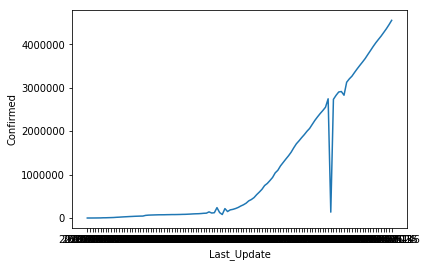

In [7]:
global_df = df.groupby('Last_Update')['Confirmed'].sum().reset_index()
sb.lineplot(data=global_df,x='Last_Update',y='Confirmed')

In [12]:
global_df[global_df.Confirmed>50000 & global_df.Confirmed<100000]

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!